# CV3DST -  implement Hungarian matching in the tracker.

#### Install and import Python libraries

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.autonotebook import tqdm

import torch
from torch.utils.data import DataLoader
from scipy.optimize import linear_sum_assignment as linear_assignment

import motmetrics as mm
mm.lap.default_solver = 'lap'
%matplotlib inline



In [ ]:
root_dir = ".."
sys.path.append(os.path.join(root_dir, "src"))


In [3]:
from tracker.data_track import MOT16Sequences
from tracker.data_obj_detect import MOT16ObjDetect
from tracker.object_detector import FRCNN_FPN
from tracker.tracker import Tracker
from tracker.utils import (
    plot_sequence,
    evaluate_mot_accums,
    get_mot_accum,
    evaluate_obj_detect,
    obj_detect_transforms,
)


/tmp/ipykernel_10147/2861463654.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# MOT16 dataset

The `MOT17Sequences` dataset class provides the possibilty to load single sequences, e.g., `seq_name = 'MOT16-02'`, or the entire train/test set, e.g., `seq_name = 'MOT16-train'`.

## Example sequences

in MOT16 dataset
sequences ['MOT16-02']


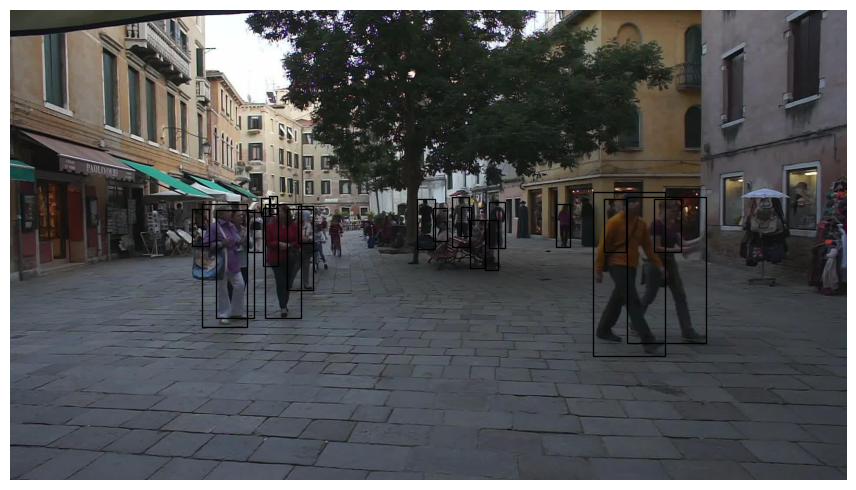

In [4]:
seq_name = "MOT16-02"
data_dir = os.path.join(root_dir, "data/MOT16")
sequences = MOT16Sequences(seq_name, data_dir, load_seg=True)  # Get a coffee.

for seq in sequences:
    for i, frame in enumerate(seq):
        img = frame["img"]

        dpi = 96
        fig, ax = plt.subplots(1, dpi=dpi)

        img = img.mul(255).permute(1, 2, 0).byte().numpy()
        width, height, _ = img.shape

        ax.imshow(img, cmap="gray")
        fig.set_size_inches(width / dpi, height / dpi)

        if "gt" in frame:
            gt = frame["gt"]
            for gt_id, box in gt.items():
                rect = plt.Rectangle(
                    (box[0], box[1]),
                    box[2] - box[0],
                    box[3] - box[1],
                    fill=False,
                    linewidth=1.0,
                )
                ax.add_patch(rect)

        plt.axis("off")
        plt.show()
        break


# Object detector

We provide you with an object detector pretrained on the MOT challenge training set for this exercise.

The object detector is a [Faster R-CNN](https://arxiv.org/abs/1506.01497) with a Resnet50 feature extractor. We trained the native PyTorch implementation of Faster-RCNN. For more information check out the corresponding PyTorch [webpage](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).


## Configuration

In [5]:
obj_detect_model_file = os.path.join(root_dir, "models/faster_rcnn_fpn.model")
obj_detect_nms_thresh = 0.3


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# object detector
obj_detect = FRCNN_FPN(num_classes=2, nms_thresh=obj_detect_nms_thresh)
obj_detect_state_dict = torch.load(
    obj_detect_model_file, map_location=lambda storage, loc: storage
)
obj_detect.load_state_dict(obj_detect_state_dict)
obj_detect.eval()
obj_detect = obj_detect.to(device)


In [7]:
dataset_test = MOT16ObjDetect(
    os.path.join(root_dir, "data/MOT16/train"), obj_detect_transforms(train=False)
)


def collate_fn(batch):
    return tuple(zip(*batch))


data_loader_test = DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn
)

# evaluate_obj_detect(obj_detect, data_loader_test)


# Multi-object tracking

We provide you with a simple baseline tracker which predicts object detections for each frame and generates tracks by assigning current detections to previous detections via Intersection over Union.

## Configuration

In [8]:
seed = 12345
seq_name = "MOT16-reid"  # We recommend to use this subset.
data_dir = os.path.join(root_dir, "data/MOT16")
output_dir = os.path.join(root_dir, "output")


## Setup

In [9]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

# dataset
sequences = MOT16Sequences(seq_name, data_dir)


in MOT16 dataset
sequences ['MOT16-02', 'MOT16-05', 'MOT16-09', 'MOT16-11']


In [10]:
# Old Tracker
class BaseTrackerIoU(Tracker):
    def data_association(self, boxes, scores):
        if self.tracks:
            track_ids = [t.id for t in self.tracks]
            track_boxes = np.stack([t.box.numpy() for t in self.tracks], axis=0)

            distance = mm.distances.iou_matrix(track_boxes, boxes.numpy(), max_iou=0.5)

            # update existing tracks
            remove_track_ids = []
            for t, dist in zip(self.tracks, distance):
                if np.isnan(dist).all():
                    remove_track_ids.append(t.id)
                else:
                    match_id = np.nanargmin(dist)
                    t.box = boxes[match_id]
            self.tracks = [t for t in self.tracks if t.id not in remove_track_ids]

            # add new tracks
            new_boxes = []
            new_scores = []
            for i, dist in enumerate(np.transpose(distance)):
                if np.isnan(dist).all():
                    new_boxes.append(boxes[i])
                    new_scores.append(scores[i])
            self.add(new_boxes, new_scores)

        else:
            self.add(boxes, scores)


##  Hungarian IoU Tracker

The previous tracker `BaseTrackerIoU` will build a cost matrix as follows: Given $n$ tracks and $m$ detected boxes, the result will be a $n\times m$ matrix with each being $1 - IoU(track, box)$ for $IoU >= 0.5$ and `np.nan` otherwise. Then, each track is extended with the best box in terms of costs. All predicted boxes, that don't overlap, i.e., $IoU < 0.5$, at all with the tracks start new tracks.

This Tracker has several issues.

One, of the issues is that this tracker does not ensure unique matching. Therefore, your task is to implement a tracker that uses hungarian matching. In the following, we provide a code fragment that you can use.

In [11]:
_UNMATCHED_COST = 255.0


class HungarianIoUTracker(Tracker):
    def data_association(self, boxes, scores):
        if self.tracks:
            track_ids = [t.id for t in self.tracks]
            track_boxes = np.stack([t.box.numpy() for t in self.tracks], axis=0)

            # Build cost matrix.
            distance = mm.distances.iou_matrix(track_boxes, boxes.numpy(), max_iou=0.5)

            # Set all unmatched costs to _UNMATCHED_COST.
            distance = np.where(np.isnan(distance), _UNMATCHED_COST, distance)
            # Perform Hungarian matching.

            # row_idx and col_idx are indices into track_boxes and boxes.
            # row_idx[i] and col_idx[i] define a match.
            # distance[row_idx[i], col_idx[i]] define the cost for that matching.
            row_idx, col_idx = linear_assignment(distance)
            min_dist = distance[row_idx, col_idx]

            # If the costs are equal to _UNMATCHED_COST, it's not a
            # match.

            condition = min_dist < _UNMATCHED_COST
            bad_idx = np.argwhere(~condition)
            good_idx = np.argwhere(condition)

            internal_idx_bad_track = row_idx[bad_idx].ravel()
            internal_idx_bad_bbox = col_idx[bad_idx].ravel()

            internal_idx_good_tracks = row_idx[good_idx].ravel()
            internal_idx_good_boxes = col_idx[good_idx].ravel()
            tracks_to_update = []

            for int_track_idx, int_box_idx in zip(
                internal_idx_good_tracks, internal_idx_good_boxes
            ):
                t = self.tracks[int_track_idx]
                t.box = boxes[int_box_idx]
                tracks_to_update.append(t)
            self.tracks = tracks_to_update

            internal_idx_unseen_boxes = set(range(len(boxes))) - set(col_idx)
            internal_idx_new_boxes = internal_idx_unseen_boxes | set(
                internal_idx_bad_bbox
            )
            new_boxes = [boxes[i] for i in internal_idx_new_boxes]
            new_scores = [scores[i] for i in internal_idx_new_boxes]

            self.add(new_boxes, new_scores)
        else:
            # No tracks exist.
            self.add(boxes, scores)


## Run tracker 
- uncomment row to run baseline tracker

In [12]:
# Old Tracker
# tracker = BaseTrackerIoU(obj_detect)

# New tracker:
tracker = HungarianIoUTracker(obj_detect)


In [ ]:
time_total = 0
mot_accums = []
results_seq = {}
for seq in sequences:
    tracker.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    data_loader = DataLoader(seq, batch_size=1, shuffle=False)

    for frame in tqdm(data_loader):
        tracker.step(frame)
    results = tracker.get_results()
    results_seq[str(seq)] = results

    if seq.no_gt:
        print(f"No GT evaluation data available.")
    else:
        mot_accums.append(get_mot_accum(results, seq))

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    # seq.write_results(results, os.path.join(output_dir))

print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(
        mot_accums, [str(s) for s in sequences if not s.no_gt], generate_overall=True
    )


## Baseline Tracker Results

            IDF1   IDP   IDR   Rcll  Prcn  GT  MT  PT ML  FP   FN IDs   FM  MOTA  MOTP
    MOT16-02 32.2% 49.8% 23.8% 30.8% 64.4%  62  5  22 35 3170 12858  52   93 13.5% 0.086
    MOT16-05 47.7% 53.9% 42.8% 57.8% 72.7% 133 39  64 30 1502  2917  87  103 34.9% 0.144
    MOT16-09 43.0% 48.8% 38.4% 51.9% 66.1%  26  7  14  5 1420  2559  39   66 24.5% 0.107
    MOT16-11 49.0% 54.1% 44.8% 55.8% 67.5%  75 15  32 28 2542  4166  20   39 28.7% 0.080
    OVERALL  41.0% 51.8% 33.9% 44.1% 67.3% 296 66 132 98 8634 22500 198  301 22.2% 0.101

## Hungarian Tracker Results

             IDF1    IDP  IDR  Rcll  Prcn   GT  MT  PT ML   FP    FN IDs   FM  MOTA  MOTP 
    MOT16-02 39.1% 55.5% 30.2% 52.3% 96.2%  62  11  38 13  383  8870 246  215 48.9% 0.096 
    MOT16-05 55.1% 65.2% 47.7% 68.8% 94.2% 133  55  66 12  295  2158 199  155 61.7% 0.143  
    MOT16-09 50.2% 62.0% 42.1% 66.4% 97.8%  26  13  12  1   80  1789  76   78 63.5% 0.083  
    MOT16-11 60.4% 66.6% 55.3% 80.2% 96.6%  75  42  26  7  266  1868  99   86 76.3% 0.083  
    OVERALL  49.0% 61.5% 40.6% 63.5% 96.2% 296 121 142 33 1024 14685 620  534 59.4% 0.099 

## Visualize tracking results

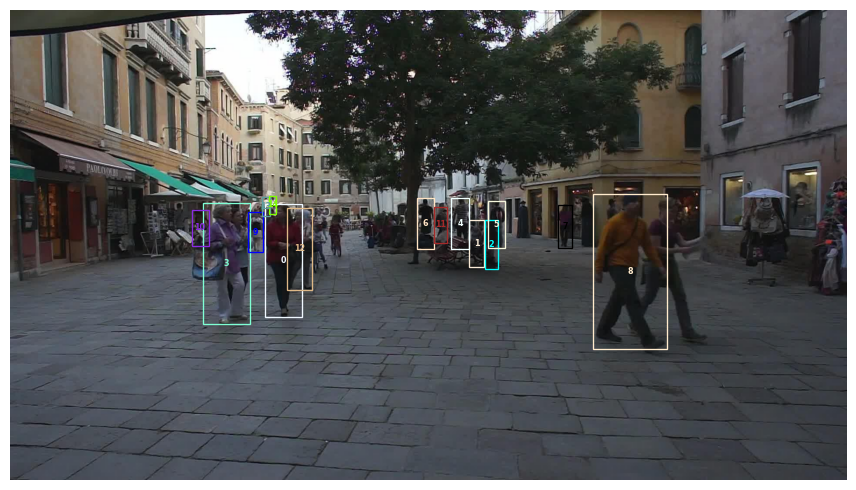

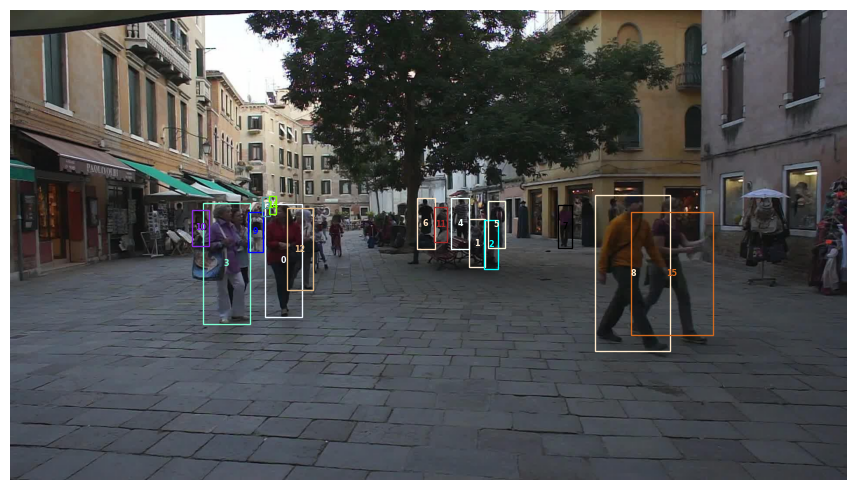

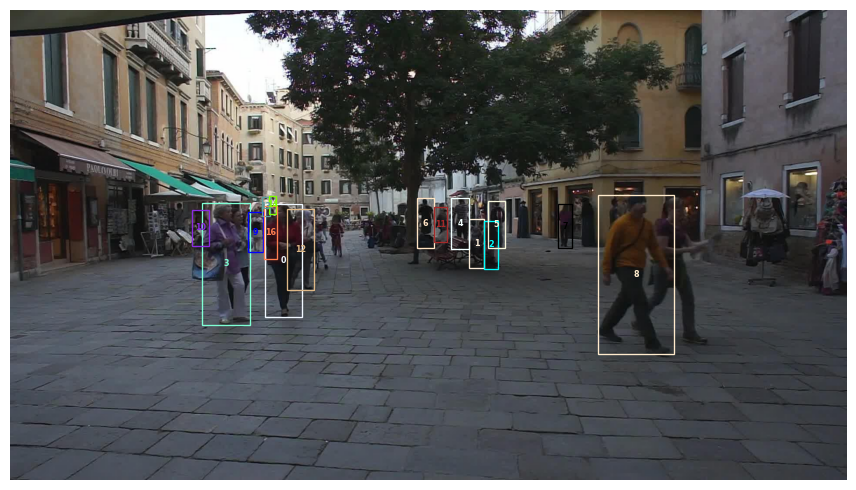

In [15]:
plot_sequence(
    results_seq["MOT16-02"],
    [s for s in sequences if str(s) == "MOT16-02"][0],
    first_n_frames=3,
)
